# Regrid between rectilinear grids


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import xarray as xr
import xesmf as xe

## Prepare data


### Input data


We regrid xarray's built-in demo data. This data is also used by
[xarray plotting tutorial](http://xarray.pydata.org/en/stable/plotting.html).


In [2]:
ds = xr.tutorial.open_dataset(
    "air_temperature"
)  # use xr.tutorial.load_dataset() for xarray<v0.11.0
ds

<xarray.Dataset>
Dimensions:  (lat: 25, time: 2920, lon: 53)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float32 ...
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

It is the air temperature data over US with 2920 time frames. Let's plot the
first frame:


In [3]:
dr = ds["air"]  # get a DataArray

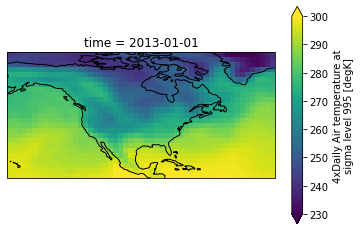

In [4]:
ax = plt.axes(projection=ccrs.PlateCarree())
dr.isel(time=0).plot.pcolormesh(ax=ax, vmin=230, vmax=300)
ax.coastlines()

### Input grid


Its grid resolution is $2.5^\circ \times 2.5^\circ$:


In [5]:
ds["lat"].values, ds["lon"].values

(array([75. , 72.5, 70. , 67.5, 65. , 62.5, 60. , 57.5, 55. , 52.5, 50. ,
        47.5, 45. , 42.5, 40. , 37.5, 35. , 32.5, 30. , 27.5, 25. , 22.5,
        20. , 17.5, 15. ], dtype=float32),
 array([200. , 202.5, 205. , 207.5, 210. , 212.5, 215. , 217.5, 220. ,
        222.5, 225. , 227.5, 230. , 232.5, 235. , 237.5, 240. , 242.5,
        245. , 247.5, 250. , 252.5, 255. , 257.5, 260. , 262.5, 265. ,
        267.5, 270. , 272.5, 275. , 277.5, 280. , 282.5, 285. , 287.5,
        290. , 292.5, 295. , 297.5, 300. , 302.5, 305. , 307.5, 310. ,
        312.5, 315. , 317.5, 320. , 322.5, 325. , 327.5, 330. ],
       dtype=float32))

### Output grid


Say we want to downsample it to $1.0^\circ \times 1.5^\circ$. Just define the
output grid as an xarray `Dataset`. Notice here that we take care of passing
some attributes to the coordinate variables. This ensures xESMF and it's
underlying helper, cf-xarray, understand which is which.


In [6]:
ds_out = xr.Dataset(
    {
        "lat": (["lat"], np.arange(16, 75, 1.0), {"units": "degrees_north"}),
        "lon": (["lon"], np.arange(200, 330, 1.5), {"units": "degrees_east"}),
    }
)
ds_out

<xarray.Dataset>
Dimensions:  (lat: 59, lon: 87)
Coordinates:
  * lat      (lat) float64 16.0 17.0 18.0 19.0 20.0 ... 70.0 71.0 72.0 73.0 74.0
  * lon      (lon) float64 200.0 201.5 203.0 204.5 ... 324.5 326.0 327.5 329.0
Data variables:
    *empty*

## Perform regridding


Make a regridder by `xe.Regridder(grid_in, grid_out, method)`. `grid` is just an
xarray `Dataset` containing `lat` and `lon` values. In most cases, `'bilinear'`
should be good enough. For other methods see
[Comparison of 5 regridding algorithms](./Compare_algorithms.ipynb).


In [7]:
regridder = xe.Regridder(ds, ds_out, "conservative")
regridder  # print basic regridder information.

xESMF Regridder 
Regridding algorithm:       conservative 
Weight filename:            conservative_25x53_59x87.nc 
Reuse pre-computed weights? False 
Input grid shape:           (25, 53) 
Output grid shape:          (59, 87) 
Periodic in longitude?      False

The regridder says it can transform data from shape `(25, 53)` to shape
`(59, 87)`.

Regrid the `DataArray` is straightforward:


In [8]:
dr_out = regridder(dr, keep_attrs=True)
dr_out

<xarray.DataArray 'air' (time: 2920, lat: 59, lon: 87)>
array([[[296.1936 , 296.4933 , 296.64383, ..., 296.6239 , 296.57   ,
         296.35767],
        [295.9    , 296.09998, 296.19998, ..., 295.9    , 295.9    ,
         295.43332],
        [295.9    , 296.09998, 296.19998, ..., 295.9    , 295.9    ,
         295.43332],
        ...,
        [243.79999, 244.26666, 244.5    , ..., 233.63335, 235.29999,
         237.96663],
        [243.79999, 244.26666, 244.5    , ..., 233.63335, 235.29999,
         237.96663],
        [241.87102, 242.6313 , 243.01498, ..., 233.68292, 235.44838,
         237.66943]],

       [[296.26776, 296.8064 , 297.0761 , ..., 296.19287, 296.17752,
         296.2103 ],
        [296.19998, 296.53333, 296.69998, ..., 295.56668, 295.5    ,
         295.23334],
        [296.19998, 296.53333, 296.69998, ..., 295.56668, 295.5    ,
         295.23334],
...
        [249.89   , 249.49   , 249.29   , ..., 241.69   , 242.48999,
         243.68997],
        [249.89   , 249.49   , 249.29   , ..., 241.69   , 242.48999,
         243.68997],
        [246.84814, 246.2443 , 245.9487 , ..., 243.05266, 243.60286,
         244.30954]],

       [[297.2945 , 297.6252 , 297.79266, ..., 296.21606, 296.0664 ,
         295.7324 ],
        [296.09   , 296.62332, 296.88998, ..., 295.69   , 295.69   ,
         295.35666],
        [296.09   , 296.62332, 296.88998, ..., 295.69   , 295.69   ,
         295.35666],
        ...,
        [249.89   , 249.49   , 249.29   , ..., 239.82333, 240.29   ,
         241.22331],
        [249.89   , 249.49   , 249.29   , ..., 239.82333, 240.29   ,
         241.22331],
        [246.3288 , 245.82306, 245.57744, ..., 241.16115, 241.18028,
         241.57034]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
  * lon      (lon) float64 200.0 201.5 203.0 204.5 ... 324.5 326.0 327.5 329.0
  * lat      (lat) float64 16.0 17.0 18.0 19.0 20.0 ... 70.0 71.0 72.0 73.0 74.0
Attributes:
    long_name:      4xDaily Air temperature at sigma level 995
    units:          degK
    precision:      2
    GRIB_id:        11
    GRIB_name:      TMP
    var_desc:       Air temperature
    dataset:        NMC Reanalysis
    level_desc:     Surface
    statistic:      Individual Obs
    parent_stat:    Other
    actual_range:   [185.16 322.1 ]
    regrid_method:  conservative

The horizontal shape is now `(59, 87)`, as expected. The regridding operation
broadcasts over extra dimensions (`time` here), so there are still 2920 time
frames. `lon` and `lat` coordinate values are updated accordingly, and the value
of the extra dimension `time` is kept the same as input.


**Important note:** Extra dimensions must be on the left, i.e.
`(time, lev, lat, lon)` is correct but `(lat, lon, time, lev)` would not work.
Most data sets should have `(lat, lon)` on the right (being the fastest changing
dimension in the memory). If not, use `DataArray.transpose` or `numpy.transpose`
to preprocess the data.


## Check results on 2D map


The regridding result is consistent with the original data, with a much finer
resolution:


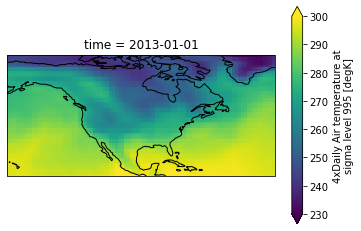

In [9]:
ax = plt.axes(projection=ccrs.PlateCarree())
dr_out.isel(time=0).plot.pcolormesh(ax=ax, vmin=230, vmax=300)
ax.coastlines()

## Check broadcasting over extra dimensions


xESMF tracks coordinate values over extra dimensions, since horizontal
regridding should not affect them.


In [10]:
dr_out["time"]

<xarray.DataArray 'time' (time: 2920)>
array(['2013-01-01T00:00:00.000000000', '2013-01-01T06:00:00.000000000',
       '2013-01-01T12:00:00.000000000', ..., '2014-12-31T06:00:00.000000000',
       '2014-12-31T12:00:00.000000000', '2014-12-31T18:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Attributes:
    standard_name:  time
    long_name:      Time

In [11]:
# exactly the same as input
xr.testing.assert_identical(dr_out["time"], ds["time"])

We can plot the time series at a specific location, to make sure the
broadcasting is correct:


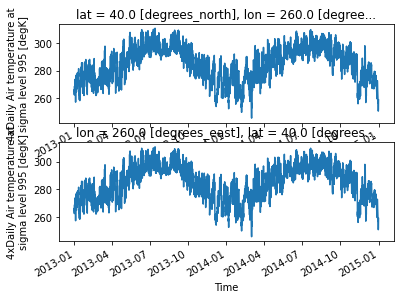

In [12]:
plt.subplot(2, 1, 1)
dr.sel(lon=260, lat=40).plot()  # input data
plt.subplot(2, 1, 2)
dr_out.sel(lon=260, lat=40).plot()  # output data